In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
from datetime import datetime, timedelta
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
import time

# 1. Data Exploration and Preprocessing for Parking Citations

In [2]:
# Load the dataset
citations_df = pd.read_csv('data/parking_citations_2025_part1_datasd.csv')
print(f"Dataset shape: {citations_df.shape}")
citations_df.head()


Dataset shape: (85533, 8)


,citation_id,date_issue,date_creation,location,sector1,vio_code,vio_desc,vio_fine
0,101636493,2025-01-01,2025-02-10,2300 PARK BLVD,CSD (I) PARKING ENF,5204(A) CVC,CURRENT REGISTRATION NOT DISPLAYED,37.5
1,101680177,2025-01-01,2025-02-10,5400 RENAISSANCE AVE,CSD (I) PARKING ENF,86.0137(G) SDMC,VEHICLE NOT MOVED 1/10 MILE IN 72 HOURS,53.5
2,101636714,2025-01-01,2025-02-10,300 S VISTA AVE,CSD (I) PARKING ENF,5204(A) CVC,CURRENT REGISTRATION NOT DISPLAYED,37.5
3,101680179,2025-01-01,2025-02-10,4200 DECORO ST,CSD (I) PARKING ENF,4000(A)1 CVC,EXPIRED REGISTRATION,52.5
4,101495542,2025-01-01,2025-02-10,14129 OLD EL CAMINO REAL,CSD (I) PARKING ENF,22500(C) CVC,"SIGNS, RED ZONES",52.5


In [3]:
citations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85533 entries, 0 to 85532
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   citation_id    85533 non-null  int64  
 1   date_issue     85533 non-null  object 
 2   date_creation  85533 non-null  object 
 3   location       85525 non-null  object 
 4   sector1        85533 non-null  object 
 5   vio_code       85533 non-null  object 
 6   vio_desc       85533 non-null  object 
 7   vio_fine       85533 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 5.2+ MB


In [4]:
citations_df.describe(include='all')

,citation_id,date_issue,date_creation,location,sector1,vio_code,vio_desc,vio_fine
count,8.553300e+04,85533,85533,85525,85533,85533,85533,85533.000000
unique,NaN,59,58,32468,5,60,60,NaN
top,NaN,2025-02-05,2025-02-10,DE ANZA BOAT LAUNCH RAMP 3500 MISSION BAY DR,CSD (I) PARKING ENF,86.0112(E)S DMC,VIOLATION OF SIGNS-STREET SWEEPING,NaN
freq,NaN,2567,2965,387,66588,17935,17935,NaN
mean,6.180743e+07,NaN,NaN,NaN,NaN,NaN,NaN,61.421340
std,4.324837e+06,NaN,NaN,NaN,NaN,NaN,NaN,55.831033
min,5.994270e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,6.131920e+07,NaN,NaN,NaN,NaN,NaN,NaN,42.500000
50%,6.134246e+07,NaN,NaN,NaN,NaN,NaN,NaN,52.500000
75%,6.136813e+07,NaN,NaN,NaN,NaN,NaN,NaN,57.500000


In [5]:
citations_df.isnull().sum()

citation_id      0
date_issue       0
date_creation    0
location         8
sector1          0
vio_code         0
vio_desc         0
vio_fine         0
dtype: int64

### 1.1 Date and Time Analysis

In [6]:
# Convert date columns to datetime
citations_df['date_issue'] = pd.to_datetime(citations_df['date_issue'])
citations_df['date_creation'] = pd.to_datetime(citations_df['date_creation'])

In [7]:
# Extract date components
citations_df['issue_year'] = citations_df['date_issue'].dt.year
citations_df['issue_month'] = citations_df['date_issue'].dt.month
citations_df['issue_day'] = citations_df['date_issue'].dt.day
citations_df['issue_dayofweek'] = citations_df['date_issue'].dt.dayofweek
citations_df['issue_dayname'] = citations_df['date_issue'].dt.day_name()
citations_df['issue_weekend'] = citations_df['issue_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [8]:
# Create month name for better readability in visualizations
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
citations_df['issue_monthname'] = citations_df['issue_month'].map(month_names)

In [9]:
# Display sample of data with new date features
citations_df[['date_issue', 'issue_year', 'issue_month', 'issue_day', 
   'issue_dayofweek', 'issue_dayname', 'issue_weekend']].head()


,date_issue,issue_year,issue_month,issue_day,issue_dayofweek,issue_dayname,issue_weekend
0,2025-01-01,2025,1,1,2,Wednesday,0
1,2025-01-01,2025,1,1,2,Wednesday,0
2,2025-01-01,2025,1,1,2,Wednesday,0
3,2025-01-01,2025,1,1,2,Wednesday,0
4,2025-01-01,2025,1,1,2,Wednesday,0


### 1.2 Violation Analysis

In [10]:
# Analyze violation codes
vio_counts = citations_df['vio_code'].value_counts().reset_index()
vio_counts.columns = ['vio_code', 'count']
vio_counts['percentage'] = (vio_counts['count'] / len(citations_df)) * 100
vio_counts.head(10)


,vio_code,count,percentage
0,86.0112(E)S DMC,17935,20.968515
1,86.0126 SDMC,16459,19.242865
2,86.0112(E)SD MC,12554,14.677376
3,86.0112(F) SDMC,7241,8.465738
4,5204(A) CVC,5746,6.717875
5,86.0105 SDMC,4010,4.688249
6,86.0119 SDMC,3238,3.785673
7,86.0111 SDMC,2749,3.213964
8,SDMC 86.2014,2333,2.727602
9,86.0121 SDMC,2116,2.473899


In [11]:
# Create a mapping of violation codes to descriptions
vio_mapping = citations_df[['vio_code', 'vio_desc']].drop_duplicates()
vio_mapping = dict(zip(vio_mapping['vio_code'], vio_mapping['vio_desc']))

# Display the mapping for the top 10 violation codes
{k: vio_mapping[k] for k in vio_counts.head(10)['vio_code']}


{'86.0112(E)S DMC': 'VIOLATION OF SIGNS-STREET SWEEPING',
 '86.0126 SDMC': 'VIOLATION OF METERED ZONE',
 '86.0112(E)SD MC': 'VIOLATION OF SIGNS (SDMC)',
 '86.0112(F) SDMC': 'RED ZONE',
 '5204(A) CVC': 'CURRENT REGISTRATION NOT DISPLAYED',
 '86.0105 SDMC': 'PASSENGER ZONE',
 '86.0119 SDMC': 'LOADING ZONE',
 '86.0111 SDMC': 'WHEEL CRAMPING-HILL',
 'SDMC 86.2014': 'RESIDENTIAL PERMIT AREA',
 '86.0121 SDMC': 'ALLEY PARKING'}

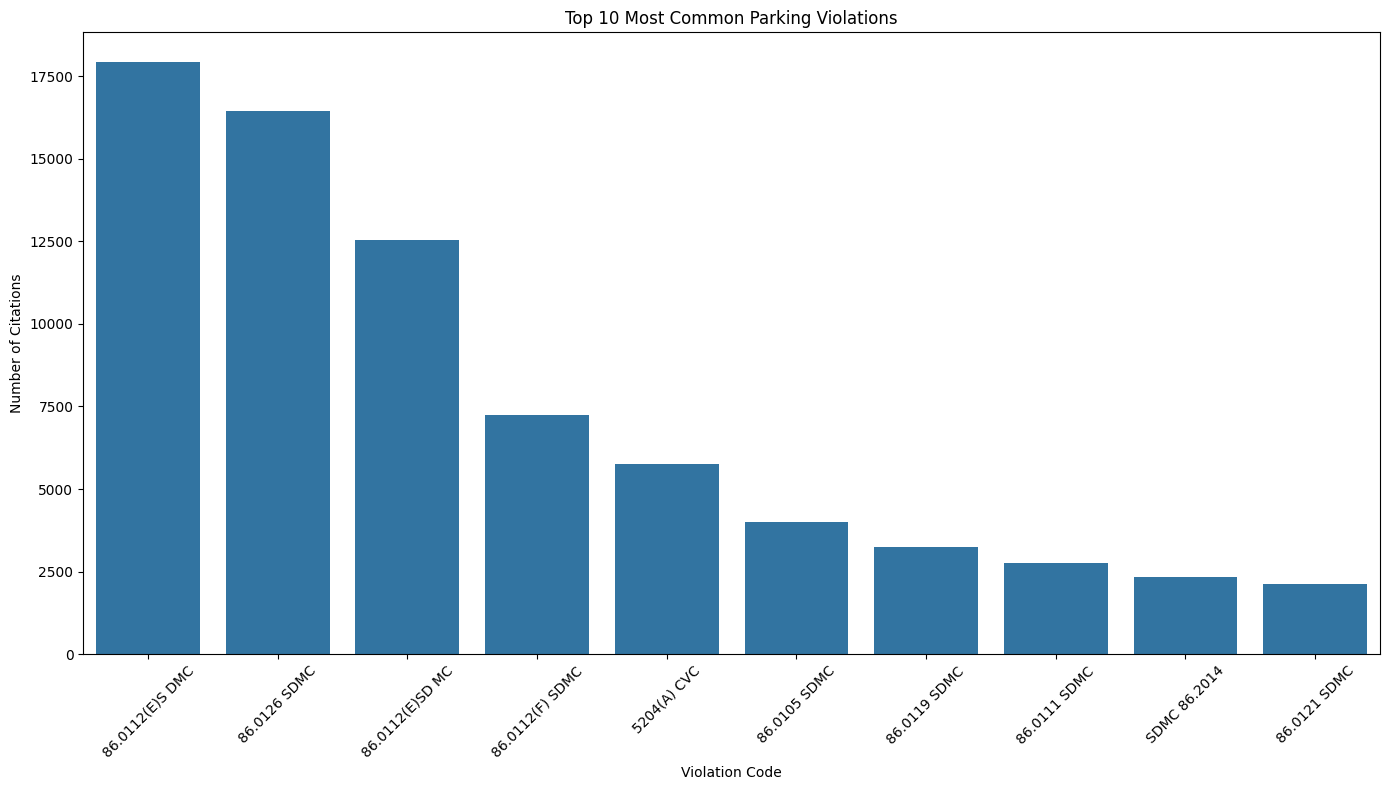

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(x='vio_code', y='count', data=vio_counts.head(10))
plt.title('Top 10 Most Common Parking Violations')
plt.xlabel('Violation Code')
plt.ylabel('Number of Citations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.3 Fine Amount Analysis

In [13]:
# Analyze fine amounts
print(f"Fine amount statistics:")
citations_df['vio_fine'].describe()

Fine amount statistics:


count    85533.000000
mean        61.421340
std         55.831033
min          0.000000
25%         42.500000
50%         52.500000
75%         57.500000
max        826.500000
Name: vio_fine, dtype: float64

In [14]:
# Group by violation code and calculate average fine
avg_fines_by_code = citations_df.groupby('vio_code')['vio_fine'].agg(['mean', 'count']).reset_index()
avg_fines_by_code = avg_fines_by_code.sort_values(by='mean', ascending=False)
avg_fines_by_code.head(10)

,vio_code,mean,count
53,86.0152(b)1 SDMC,826.500000,34
54,86.0152(b)2 SDMC,826.500000,31
55,86.0152(b)3 SDMC,826.500000,18
16,22507.8(c)CVC,452.500000,93
15,22507.8(b)CVC,452.500000,13
14,22507.8(a)CVC,418.731343,871
12,22507.8 CVC,362.000000,5
9,22500(L) CVC,302.500000,918
8,22500(I) CVC,277.500000,96
47,86.0137(I) SDMC,262.500000,92


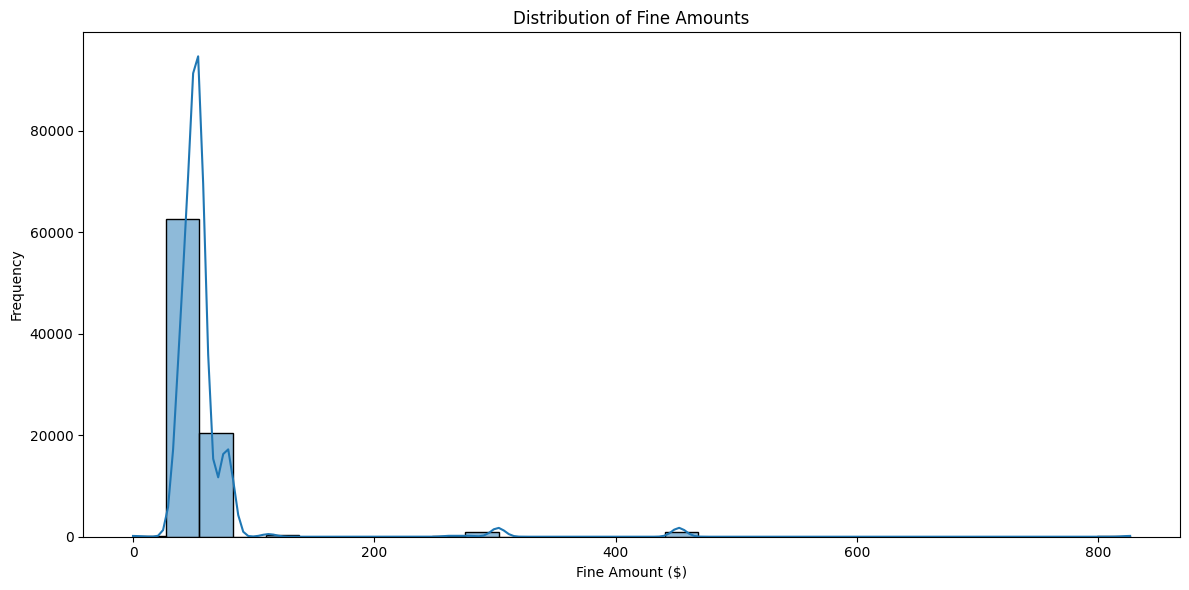

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(citations_df['vio_fine'].dropna(), bins=30, kde=True)
plt.title('Distribution of Fine Amounts')
plt.xlabel('Fine Amount ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

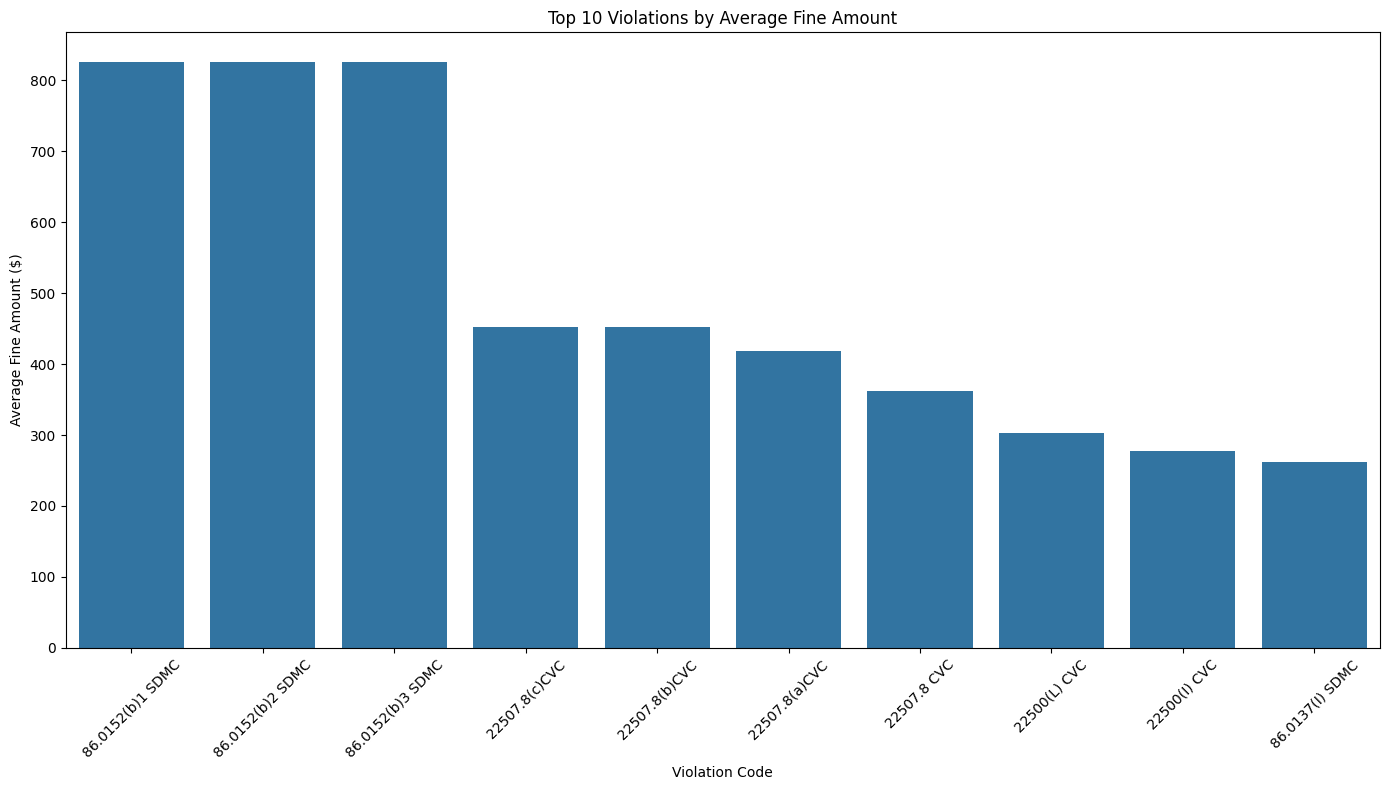

In [ ]:
top_fines = avg_fines_by_code.head(10)
plt.figure(figsize=(14, 8))
sns.barplot(x='vio_code', y='mean', data=top_fines)
plt.title('Top 10 Violations by Average Fine Amount')
plt.xlabel('Violation Code')
plt.ylabel('Average Fine Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.4 Location Analysis

In [17]:
# Analyze citation locations
location_counts = citations_df['location'].value_counts().reset_index()
location_counts.columns = ['location', 'count']
location_counts['percentage'] = (location_counts['count'] / len(citations_df)) * 100
location_counts.head(10)

,location,count,percentage
0,DE ANZA BOAT LAUNCH RAMP 3500 MISSION BAY DR,387,0.452457
1,1700 KETTNER BL,243,0.284101
2,1500 ISLAND AV,208,0.243181
3,SKI BEACH NORTH 3300 INGRAHAM ST,202,0.236166
4,1200 UNIVERSITY AV,199,0.232659
5,1400 ISLAND AV,194,0.226813
6,1300 K ST,167,0.195246
7,500 4TH AV,166,0.194077
8,800 13TH ST,147,0.171863
9,500 13TH ST,141,0.164849


In [18]:
# Analyze sectors
sector_counts = citations_df['sector1'].value_counts().reset_index()
sector_counts.columns = ['sector', 'count']
sector_counts['percentage'] = (sector_counts['count'] / len(citations_df)) * 100
sector_counts

,sector,count,percentage
0,CSD (I) PARKING ENF,66588,77.850654
1,CSD (G) STREET SWEEPING,18045,21.097120
2,CSD (S) POLICE,644,0.752926
3,CSD (R) METER OPS,250,0.292285
4,CSD (W) PARK RANGERS,6,0.007015


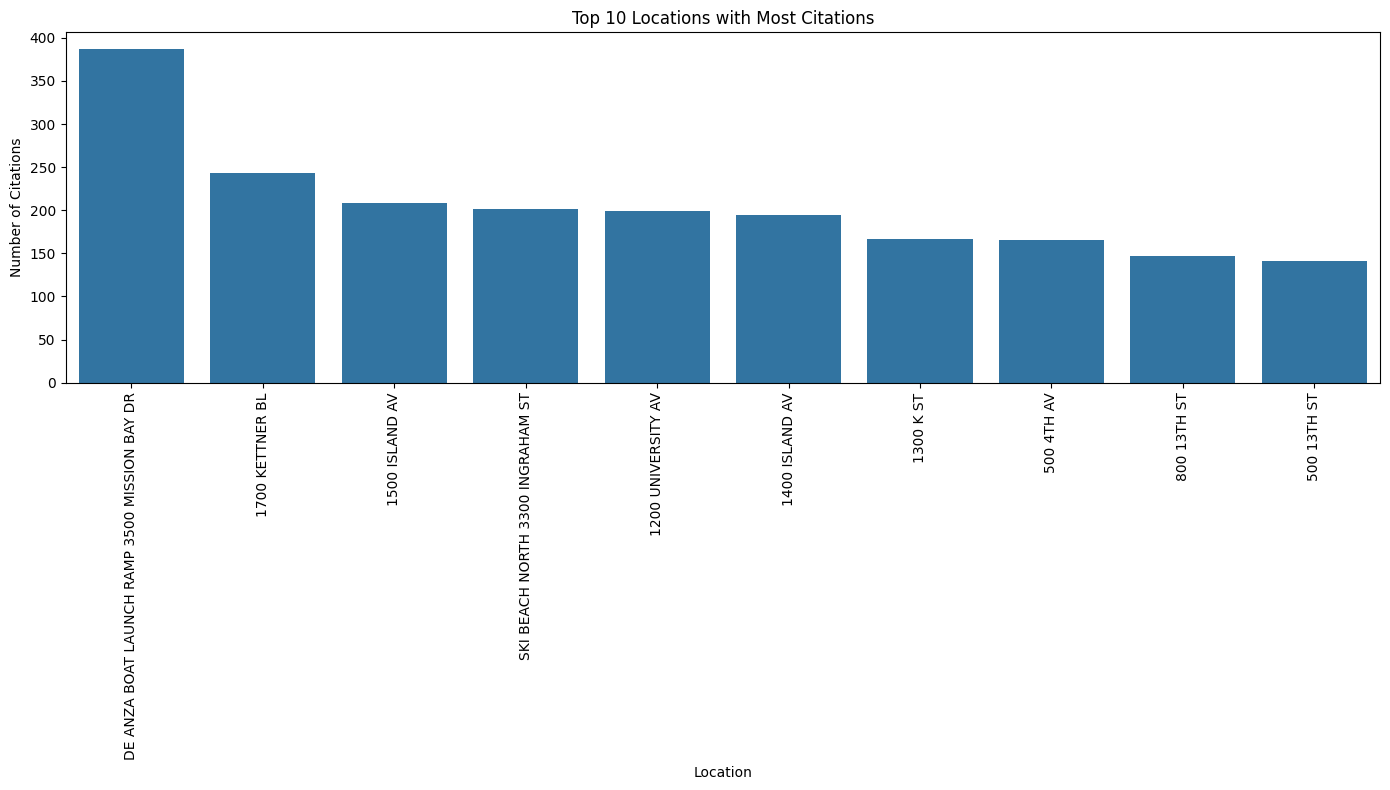

In [19]:
# Visualize top 10 locations
plt.figure(figsize=(14, 8))
sns.barplot(x='location', y='count', data=location_counts.head(10))
plt.title('Top 10 Locations with Most Citations')
plt.xlabel('Location')
plt.ylabel('Number of Citations')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

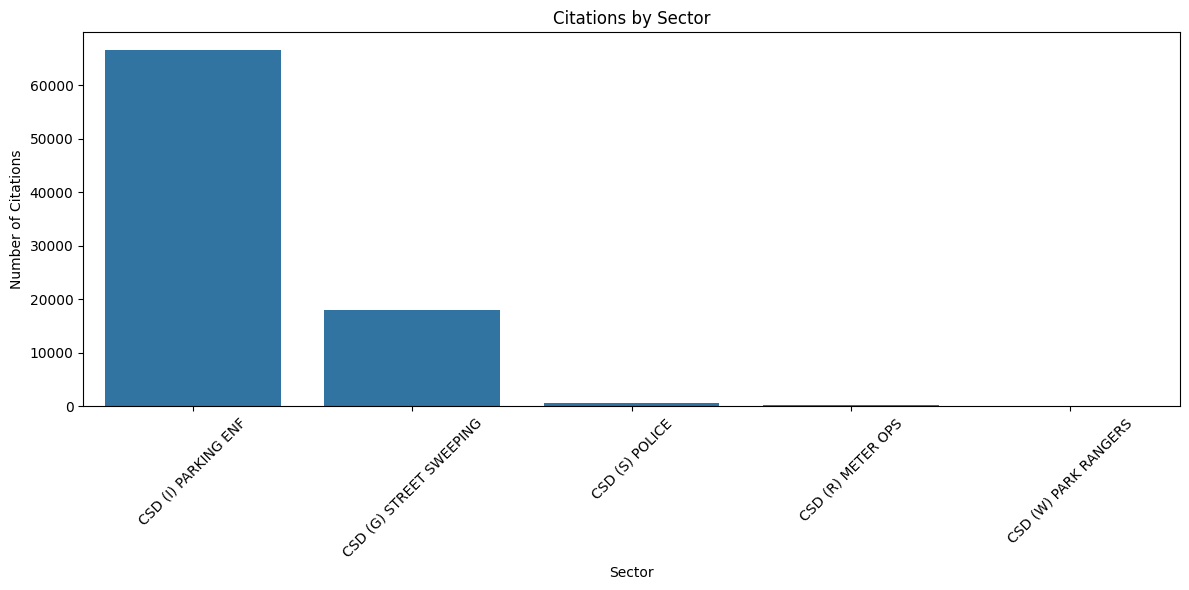

In [20]:
# Visualize citations by sector
plt.figure(figsize=(12, 6))
sns.barplot(x='sector', y='count', data=sector_counts)
plt.title('Citations by Sector')
plt.xlabel('Sector')
plt.ylabel('Number of Citations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.5 Temporal Patterns

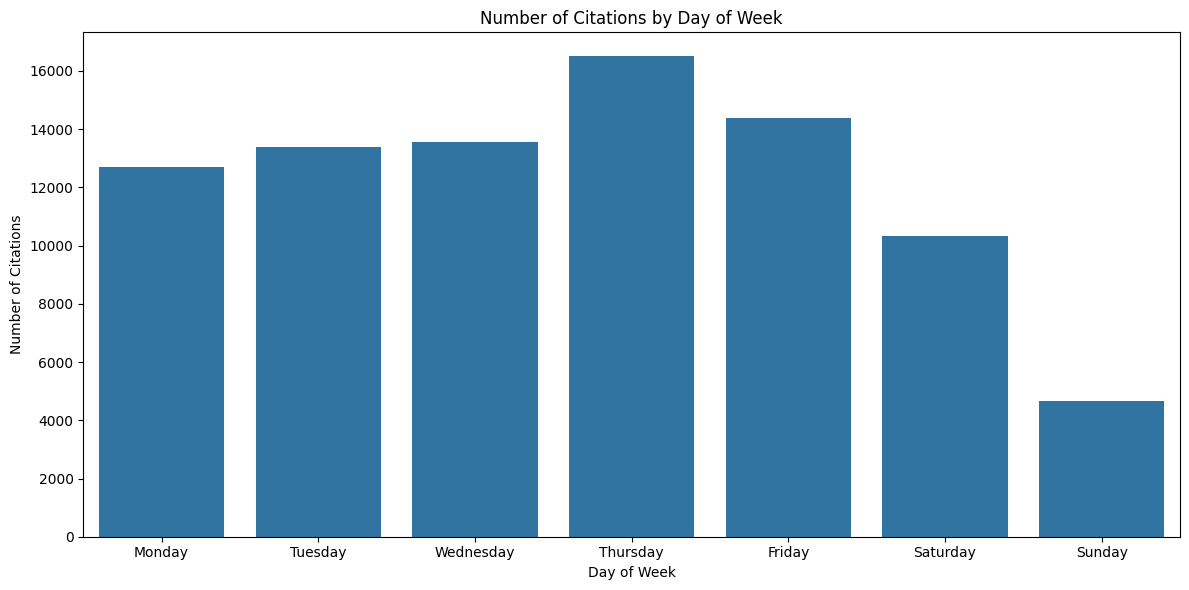

In [21]:
# Analyze citations by day of week
plt.figure(figsize=(12, 6))
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.countplot(x='issue_dayname', data=citations_df, order=day_order)
plt.title('Number of Citations by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Citations')
plt.tight_layout()
plt.show()


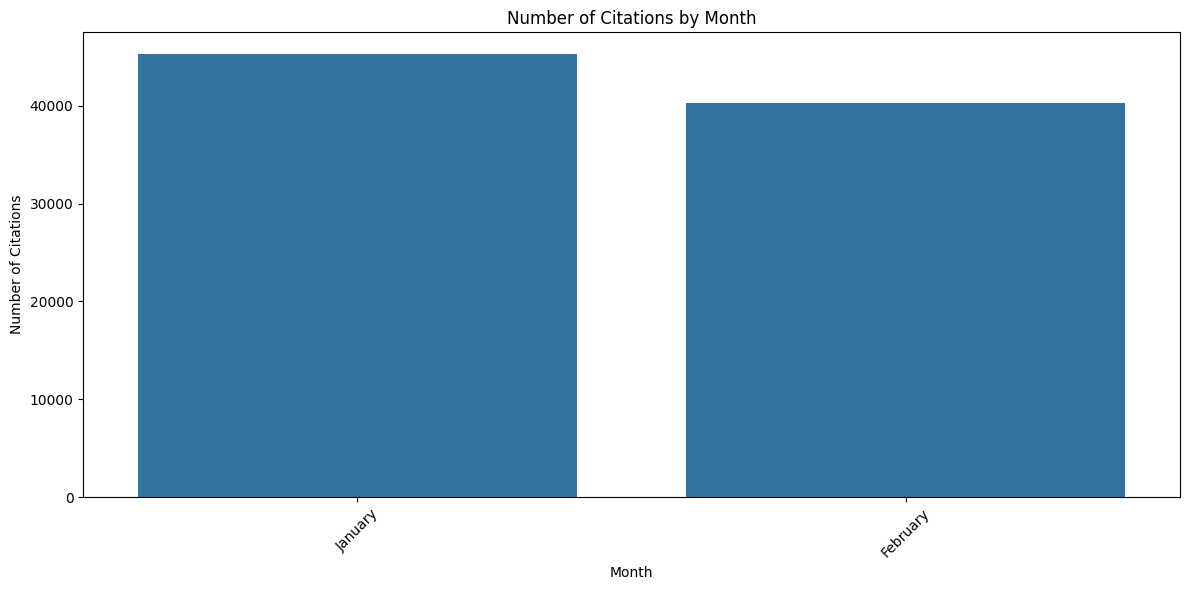

In [22]:
# Analyze citations by month
plt.figure(figsize=(12, 6))
month_order = [month_names[i] for i in range(1, 13) if i in citations_df['issue_month'].unique()]
sns.countplot(x='issue_monthname', data=citations_df, order=month_order)
plt.title('Number of Citations by Month')
plt.xlabel('Month')
plt.ylabel('Number of Citations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.6 Heatmap Analysis

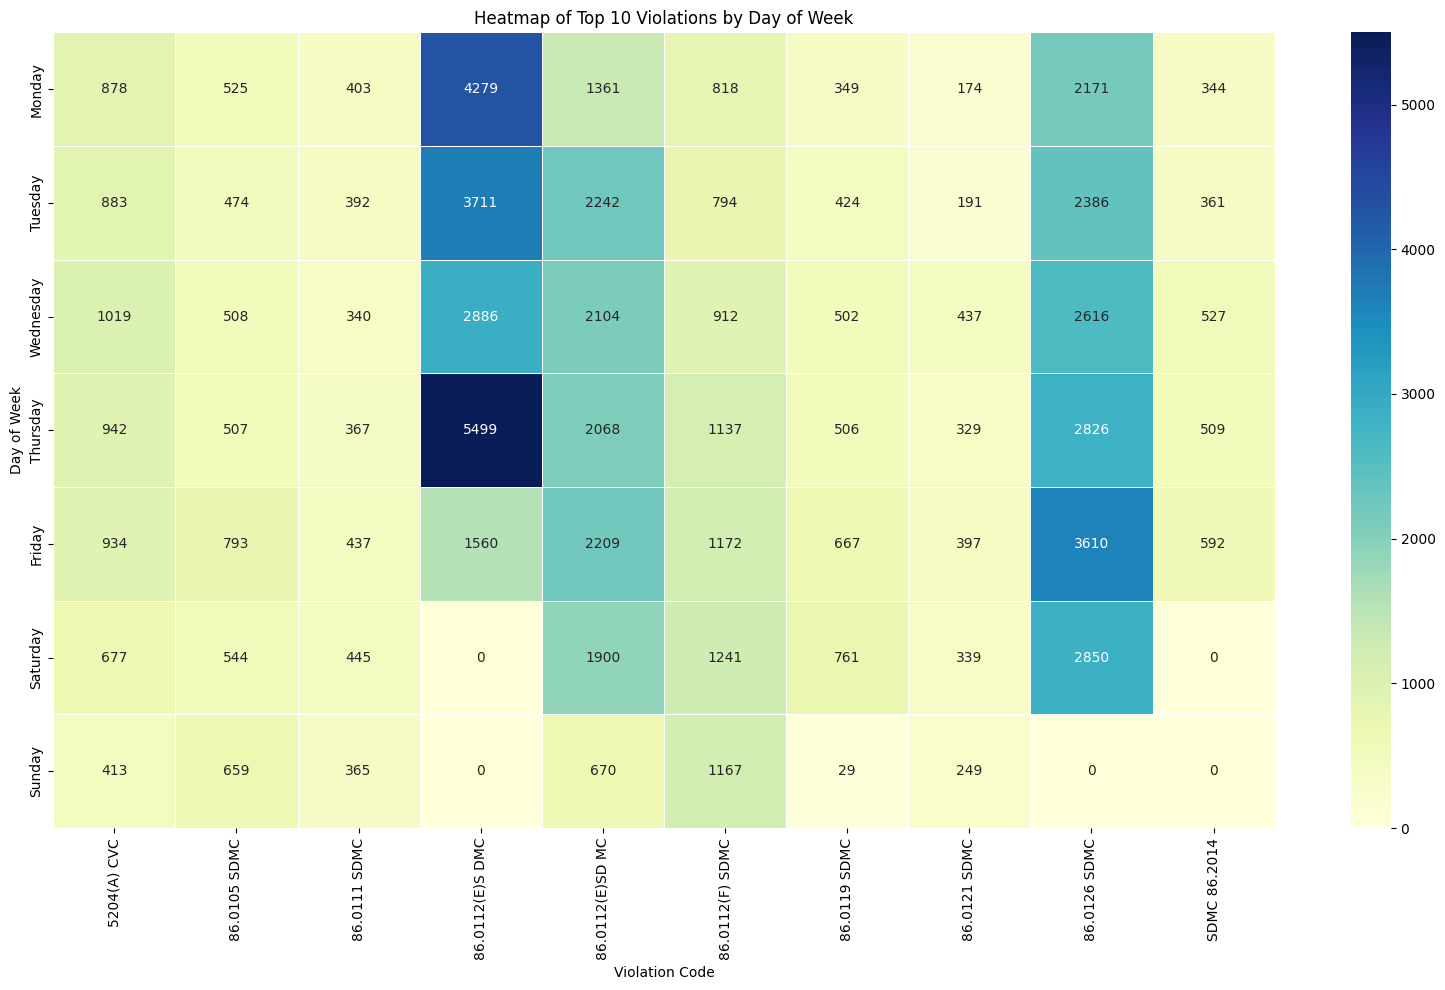

In [23]:
# Create heatmap of top violations by day of week
# Get top 10 violations for better visibility
top_10_violations = vio_counts.head(10)['vio_code'].tolist()
day_vio_counts = citations_df[citations_df['vio_code'].isin(top_10_violations)].groupby(['issue_dayname', 'vio_code']).size().unstack().fillna(0)
# Reorder rows to start with Monday
day_vio_counts = day_vio_counts.reindex(day_order)
plt.figure(figsize=(16, 10))
sns.heatmap(day_vio_counts, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=.5)
plt.title('Heatmap of Top 10 Violations by Day of Week')
plt.xlabel('Violation Code')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

### 1.7 Relationship Between Variables

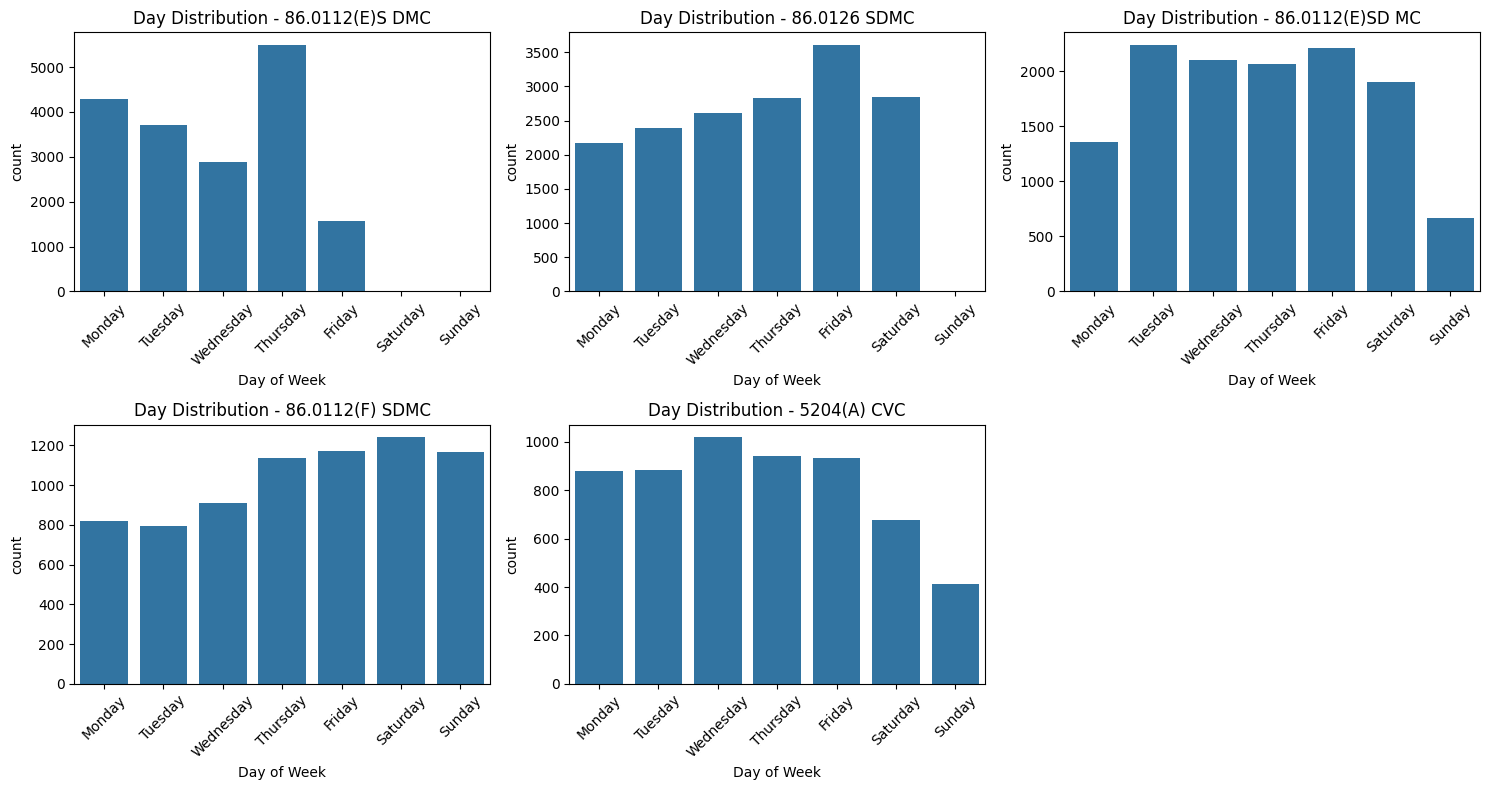

In [24]:
# Relationship between violation type and day of week
plt.figure(figsize=(15, 8))
for i, vio in enumerate(top_10_violations[:5]):  # Just show top 5 for clarity
    plt.subplot(2, 3, i+1)
    vio_data = citations_df[citations_df['vio_code'] == vio]
    sns.countplot(x='issue_dayname', data=vio_data, order=day_order)
    plt.title(f'Day Distribution - {vio}')
    plt.xlabel('Day of Week')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.8 Data Quality Checks

In [25]:
# Check for duplicates
duplicate_count = citations_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [26]:
# Check for outliers in fine amounts
q1 = citations_df['vio_fine'].quantile(0.25)
q3 = citations_df['vio_fine'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = citations_df[(citations_df['vio_fine'] < lower_bound) | (citations_df['vio_fine'] > upper_bound)]
print(f"Number of potential fine amount outliers: {len(outliers)}")
print(f"Minimum outlier value: {outliers['vio_fine'].min()}")
print(f"Maximum outlier value: {outliers['vio_fine'].max()}")

Number of potential fine amount outliers: 2469
Minimum outlier value: 0.0
Maximum outlier value: 826.5


### 1.9 Data Preprocessing for Modeling

In [27]:
# Handle missing values
print("Missing values before handling:")
print(citations_df.isnull().sum())

Missing values before handling:
citation_id        0
date_issue         0
date_creation      0
location           8
sector1            0
vio_code           0
vio_desc           0
vio_fine           0
issue_year         0
issue_month        0
issue_day          0
issue_dayofweek    0
issue_dayname      0
issue_weekend      0
issue_monthname    0
dtype: int64


In [28]:
# Strategy for handling missing dates
citations_df = citations_df.dropna(subset=['date_issue']).copy()  # Remove rows with missing issue dates

In [29]:
# For missing sectors or locations, fill with a placeholder
citations_df['sector1'] = citations_df['sector1'].fillna('Unknown')
citations_df['location'] = citations_df['location'].fillna('Unknown')
print("Missing values after handling:")
print(citations_df.isnull().sum())

Missing values after handling:
citation_id        0
date_issue         0
date_creation      0
location           0
sector1            0
vio_code           0
vio_desc           0
vio_fine           0
issue_year         0
issue_month        0
issue_day          0
issue_dayofweek    0
issue_dayname      0
issue_weekend      0
issue_monthname    0
dtype: int64


In [30]:
# For categorical predictors, identify columns that need encoding
categorical_cols = ['sector1', 'issue_dayname', 'issue_monthname', 'issue_weekend']
print(f"Categorical columns to encode: {categorical_cols}")

Categorical columns to encode: ['sector1', 'issue_dayname', 'issue_monthname', 'issue_weekend']


In [31]:
# One-hot encode top locations (for demo purposes, just encode the top 20)
top_locations = location_counts.head(20)['location'].tolist()
for loc in top_locations:
    citations_df[f'loc_{loc}'] = citations_df['location'].apply(lambda x: 1 if x == loc else 0)

print(f"Added {len(top_locations)} location dummy variables")
citations_df.head()

Added 20 location dummy variables


,citation_id,date_issue,date_creation,location,sector1,vio_code,vio_desc,vio_fine,issue_year,issue_month,...,loc_900 GARNET AV,loc_800 HORNBLEND ST,loc_1374 ISLAND AV,loc_400 13TH ST,loc_9500 LA JOLLA SHORES DR,loc_4000 30TH ST,loc_1300 3RD AV,loc_1429 ISLAND AV,loc_500 6TH AV,loc_600 6TH AV
0,101636493,2025-01-01,2025-02-10,2300 PARK BLVD,CSD (I) PARKING ENF,5204(A) CVC,CURRENT REGISTRATION NOT DISPLAYED,37.5,2025,1,...,0,0,0,0,0,0,0,0,0,0
1,101680177,2025-01-01,2025-02-10,5400 RENAISSANCE AVE,CSD (I) PARKING ENF,86.0137(G) SDMC,VEHICLE NOT MOVED 1/10 MILE IN 72 HOURS,53.5,2025,1,...,0,0,0,0,0,0,0,0,0,0
2,101636714,2025-01-01,2025-02-10,300 S VISTA AVE,CSD (I) PARKING ENF,5204(A) CVC,CURRENT REGISTRATION NOT DISPLAYED,37.5,2025,1,...,0,0,0,0,0,0,0,0,0,0
3,101680179,2025-01-01,2025-02-10,4200 DECORO ST,CSD (I) PARKING ENF,4000(A)1 CVC,EXPIRED REGISTRATION,52.5,2025,1,...,0,0,0,0,0,0,0,0,0,0
4,101495542,2025-01-01,2025-02-10,14129 OLD EL CAMINO REAL,CSD (I) PARKING ENF,22500(C) CVC,"SIGNS, RED ZONES",52.5,2025,1,...,0,0,0,0,0,0,0,0,0,0


### 1.10 Summary of Findings

In [32]:
# Print summary of key findings for further modeling
print("Summary of Key Findings:")
print(f"- Dataset contains {citations_df.shape[0]} parking citations with {len(vio_mapping)} unique violation types")
print(f"- Top 3 most common violations: {', '.join(vio_counts.head(3)['vio_code'].tolist())}")
print(f"- Violations with highest average fines: {', '.join(avg_fines_by_code.head(3)['vio_code'].tolist())}")
print(f"- Most citations occur on {citations_df['issue_dayname'].value_counts().index[0]}s")
print(f"- {len(location_counts)} unique locations with citations, top location: {location_counts.iloc[0]['location']}")
print(f"- {citations_df['sector1'].nunique()} unique sectors with citations")
print("- Created time-based features that may help predict violation types")

Summary of Key Findings:
- Dataset contains 85533 parking citations with 60 unique violation types
- Top 3 most common violations: 86.0112(E)S DMC, 86.0126 SDMC, 86.0112(E)SD MC
- Violations with highest average fines: 86.0152(b)1 SDMC, 86.0152(b)2 SDMC, 86.0152(b)3 SDMC
- Most citations occur on Thursdays
- 32468 unique locations with citations, top location: DE ANZA BOAT LAUNCH RAMP 3500 MISSION BAY DR
- 5 unique sectors with citations
- Created time-based features that may help predict violation types


# 2. Feature Engineering for Parking Citations Prediction

### 2.1 Define Target Variable

In [33]:
target_column = 'vio_code'

# Check target distribution
target_counts = citations_df[target_column].value_counts()
print(f"Number of unique violation codes: {len(target_counts)}")
print("Top 10 violation codes by frequency:")
print(target_counts.head(10))

Number of unique violation codes: 60
Top 10 violation codes by frequency:
vio_code
86.0112(E)S DMC    17935
86.0126 SDMC       16459
86.0112(E)SD MC    12554
86.0112(F) SDMC     7241
5204(A) CVC         5746
86.0105 SDMC        4010
86.0119 SDMC        3238
86.0111 SDMC        2749
SDMC 86.2014        2333
86.0121 SDMC        2116
Name: count, dtype: int64


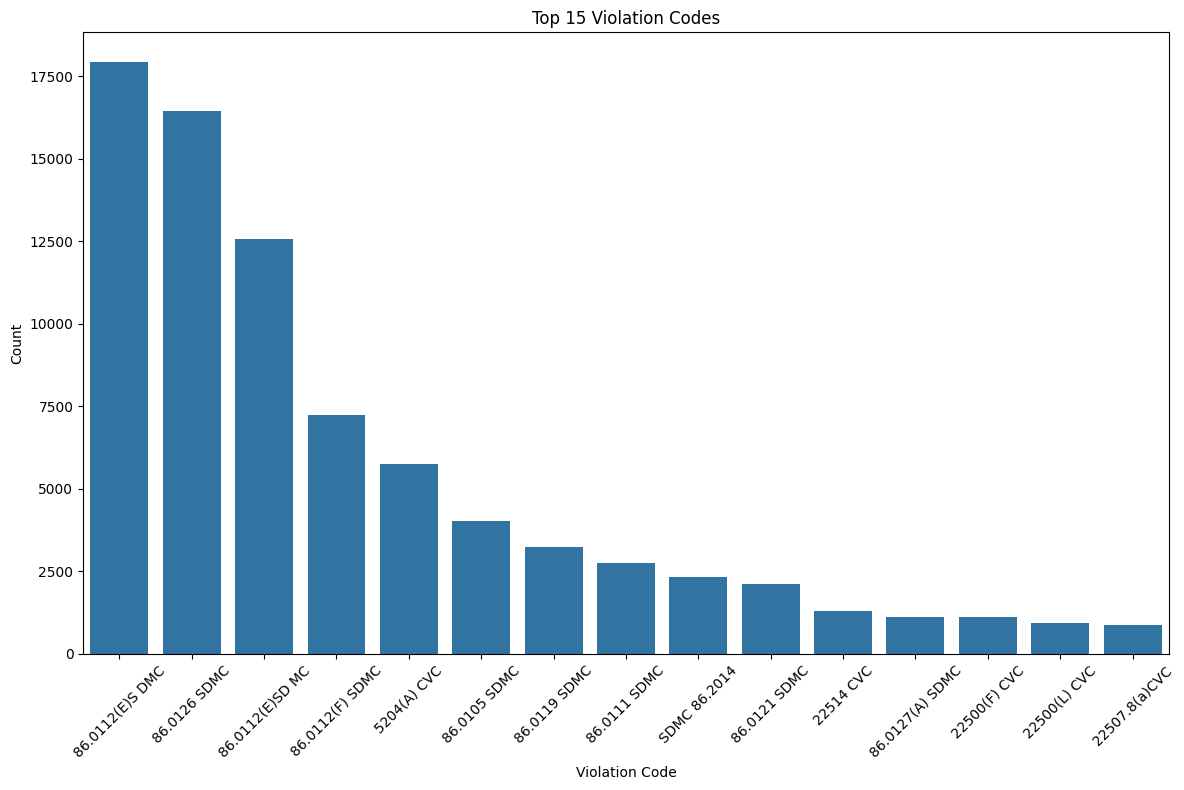

In [ ]:
plt.figure(figsize=(12, 8))
top_violations = target_counts.head(15).reset_index()
top_violations.columns = ['violation', 'count']
sns.barplot(x='violation', y='count', data=top_violations)
plt.title('Top 15 Violation Codes')
plt.xlabel('Violation Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Check if target has too many classes - if so, we might want to focus on top N classes
if len(target_counts) > 20:
    print(f"Note: Target has {len(target_counts)} classes. Consider focusing on top classes.")
    
    # Get descriptions for top violations
    top_violations_list = target_counts.head(10).index.tolist()
    vio_desc_mapping = citations_df[['vio_code', 'vio_desc']].drop_duplicates().set_index('vio_code')['vio_desc'].to_dict()
    
    print("\nTop 10 violations with descriptions:")
    for vio in top_violations_list:
        print(f"{vio}: {vio_desc_mapping.get(vio, 'No description')}")
    
    # For this project, we'll focus on the top 10 violation codes
    citations_filtered = citations_df[citations_df[target_column].isin(top_violations_list)].copy()
    print(f"\nFiltered dataset shape: {citations_filtered.shape}")
else:
    citations_filtered = citations_df.copy()

Note: Target has 60 classes. Consider focusing on top classes.

Top 10 violations with descriptions:
86.0112(E)S DMC: VIOLATION OF SIGNS-STREET SWEEPING
86.0126 SDMC: VIOLATION OF METERED ZONE
86.0112(E)SD MC: VIOLATION OF SIGNS (SDMC)
86.0112(F) SDMC: RED ZONE
5204(A) CVC: CURRENT REGISTRATION NOT DISPLAYED
86.0105 SDMC: PASSENGER ZONE
86.0119 SDMC: LOADING ZONE
86.0111 SDMC: WHEEL CRAMPING-HILL
SDMC 86.2014: RESIDENTIAL PERMIT AREA
86.0121 SDMC: ALLEY PARKING

Filtered dataset shape: (74381, 35)


### 2.2 Handle Date and Time Format

In [36]:
# First, check if date_issue is already in datetime format
if not pd.api.types.is_datetime64_any_dtype(citations_filtered['date_issue']):
    # Convert to datetime format if it's not already
    citations_filtered['date_issue'] = pd.to_datetime(citations_filtered['date_issue'], errors='coerce')
    print("Converted date_issue to datetime format")

print(f"Missing date values: {citations_filtered['date_issue'].isnull().sum()}")
print(f"Date range: {citations_filtered['date_issue'].min()} to {citations_filtered['date_issue'].max()}")

Missing date values: 0
Date range: 2025-01-01 00:00:00 to 2025-02-28 00:00:00


In [37]:
# Extract date components that may be useful
citations_filtered['issue_year'] = citations_filtered['date_issue'].dt.year
citations_filtered['issue_month'] = citations_filtered['date_issue'].dt.month
citations_filtered['issue_day'] = citations_filtered['date_issue'].dt.day
citations_filtered['issue_dayofweek'] = citations_filtered['date_issue'].dt.dayofweek
citations_filtered['issue_dayname'] = citations_filtered['date_issue'].dt.day_name()
citations_filtered['issue_quarter'] = citations_filtered['date_issue'].dt.quarter
citations_filtered['issue_weekofyear'] = citations_filtered['date_issue'].dt.isocalendar().week

### 2.3 Temporal Features

In [38]:
# Weekend indicator
citations_filtered['is_weekend'] = (citations_filtered['issue_dayofweek'] >= 5).astype(int)

# Part of week
citations_filtered['part_of_week'] = citations_filtered['issue_dayofweek'].apply(
    lambda x: 'start_week' if x < 2 else ('mid_week' if x < 5 else 'weekend')
)

# Season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

citations_filtered['season'] = citations_filtered['issue_month'].apply(get_season)

# Part of month (beginning, middle, end)
citations_filtered['part_of_month'] = pd.cut(
    citations_filtered['issue_day'],
    bins=[0, 10, 20, 31],
    labels=['beginning', 'middle', 'end']
)

# Cyclical encoding for month and day of week (since these are cyclical variables)
citations_filtered['month_sin'] = np.sin(2 * np.pi * citations_filtered['issue_month']/12)
citations_filtered['month_cos'] = np.cos(2 * np.pi * citations_filtered['issue_month']/12)
citations_filtered['dayofweek_sin'] = np.sin(2 * np.pi * citations_filtered['issue_dayofweek']/7)
citations_filtered['dayofweek_cos'] = np.cos(2 * np.pi * citations_filtered['issue_dayofweek']/7)

### 2.4 Location-Based Features

In [39]:
# Count of citations per location (location popularity)
location_citation_counts = citations_filtered['location'].value_counts()
citations_filtered['location_popularity'] = citations_filtered['location'].map(location_citation_counts)

# Group locations by frequency (high, medium, low)
location_thresholds = [0, 50, 200, float('inf')]
location_labels = ['low_freq', 'medium_freq', 'high_freq']
citations_filtered['location_frequency_group'] = pd.cut(
    citations_filtered['location_popularity'],
    bins=location_thresholds,
    labels=location_labels
)

# Location-based violation patterns
# For each location, calculate the most common violation
location_top_violation = citations_filtered.groupby('location')[target_column].agg(
    lambda x: pd.Series.mode(x)[0] if not pd.Series.mode(x).empty else None
).to_dict()

# Add a feature indicating if this citation matches the most common violation for its location
citations_filtered['matches_location_top_violation'] = (
    citations_filtered.apply(
        lambda row: row[target_column] == location_top_violation.get(row['location'], None),
        axis=1
    )
).astype(int)

# Sector analysis
sector_citation_counts = citations_filtered['sector1'].value_counts()
citations_filtered['sector_popularity'] = citations_filtered['sector1'].map(sector_citation_counts)


### 2.5 Interaction Features

In [40]:
# Location-Day of Week interaction
citations_filtered['loc_day_interaction'] = citations_filtered['location'] + '_' + citations_filtered['issue_dayname']

# Location-Month interaction
citations_filtered['loc_month_interaction'] = citations_filtered['location'] + '_' + citations_filtered['issue_month'].astype(str)

# Sector-Day of week interactions
citations_filtered['sector_day_interaction'] = citations_filtered['sector1'] + '_' + citations_filtered['issue_dayname']

# Sector-Month interactions
citations_filtered['sector_month_interaction'] = citations_filtered['sector1'] + '_' + citations_filtered['issue_month'].astype(str)

# Season-Location interaction
citations_filtered['season_location'] = citations_filtered['season'] + '_' + citations_filtered['location']

### 2.6 Statistical Features

In [41]:
# Day of week probability
day_violation_prob = {}
for day in range(7):
    day_data = citations_filtered[citations_filtered['issue_dayofweek'] == day]
    if len(day_data) > 0:
        violation_dist = day_data[target_column].value_counts(normalize=True).to_dict()
        day_violation_prob[day] = violation_dist

# Add day probability features for top violations
for vio in top_violations_list:
    citations_filtered[f'day_prob_{vio}'] = citations_filtered['issue_dayofweek'].apply(
        lambda d: day_violation_prob.get(d, {}).get(vio, 0)
    )

# Month probability
month_violation_prob = {}
for month in range(1, 13):
    month_data = citations_filtered[citations_filtered['issue_month'] == month]
    if len(month_data) > 0:
        violation_dist = month_data[target_column].value_counts(normalize=True).to_dict()
        month_violation_prob[month] = violation_dist

# Add month probability features for top violations
for vio in top_violations_list:
    citations_filtered[f'month_prob_{vio}'] = citations_filtered['issue_month'].apply(
        lambda m: month_violation_prob.get(m, {}).get(vio, 0)
    )

### 2.7 Additional Features Based on Domain Knowledge

In [42]:
# Is holiday or special day (simplified example)
us_holidays = [
    # Format: (month, day) tuples
    (1, 1),    # New Year's Day
    (7, 4),    # Independence Day
    (12, 25),  # Christmas
    # Add more holidays as needed
]

citations_filtered['is_holiday'] = citations_filtered.apply(
    lambda row: 1 if (row['issue_month'], row['issue_day']) in us_holidays else 0, 
    axis=1
)

# Days since beginning of month
citations_filtered['days_since_month_start'] = citations_filtered['issue_day'] - 1

# Days until end of month (approximate)
days_in_month = {
    1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
    7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31
}
citations_filtered['days_until_month_end'] = citations_filtered.apply(
    lambda row: days_in_month[row['issue_month']] - row['issue_day'],
    axis=1
)

# Is weekend adjacent (Friday or Monday)
citations_filtered['is_weekend_adjacent'] = citations_filtered['issue_dayofweek'].apply(
    lambda d: 1 if d in [0, 4] else 0  # Monday or Friday
)

### 2.8 Feature Selection and Transformation

C:\Users\tommy\AppData\Local\Temp\ipykernel_11880\2879680381.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  or pd.api.types.is_categorical_dtype(citations_filtered[col]))


Categorical columns to encode: ['sector1', 'issue_dayname', 'issue_monthname', 'part_of_week', 'season', 'part_of_month', 'location_frequency_group']
After one-hot encoding categorical features, shape: (74381, 88)
Number of numerical features: 78


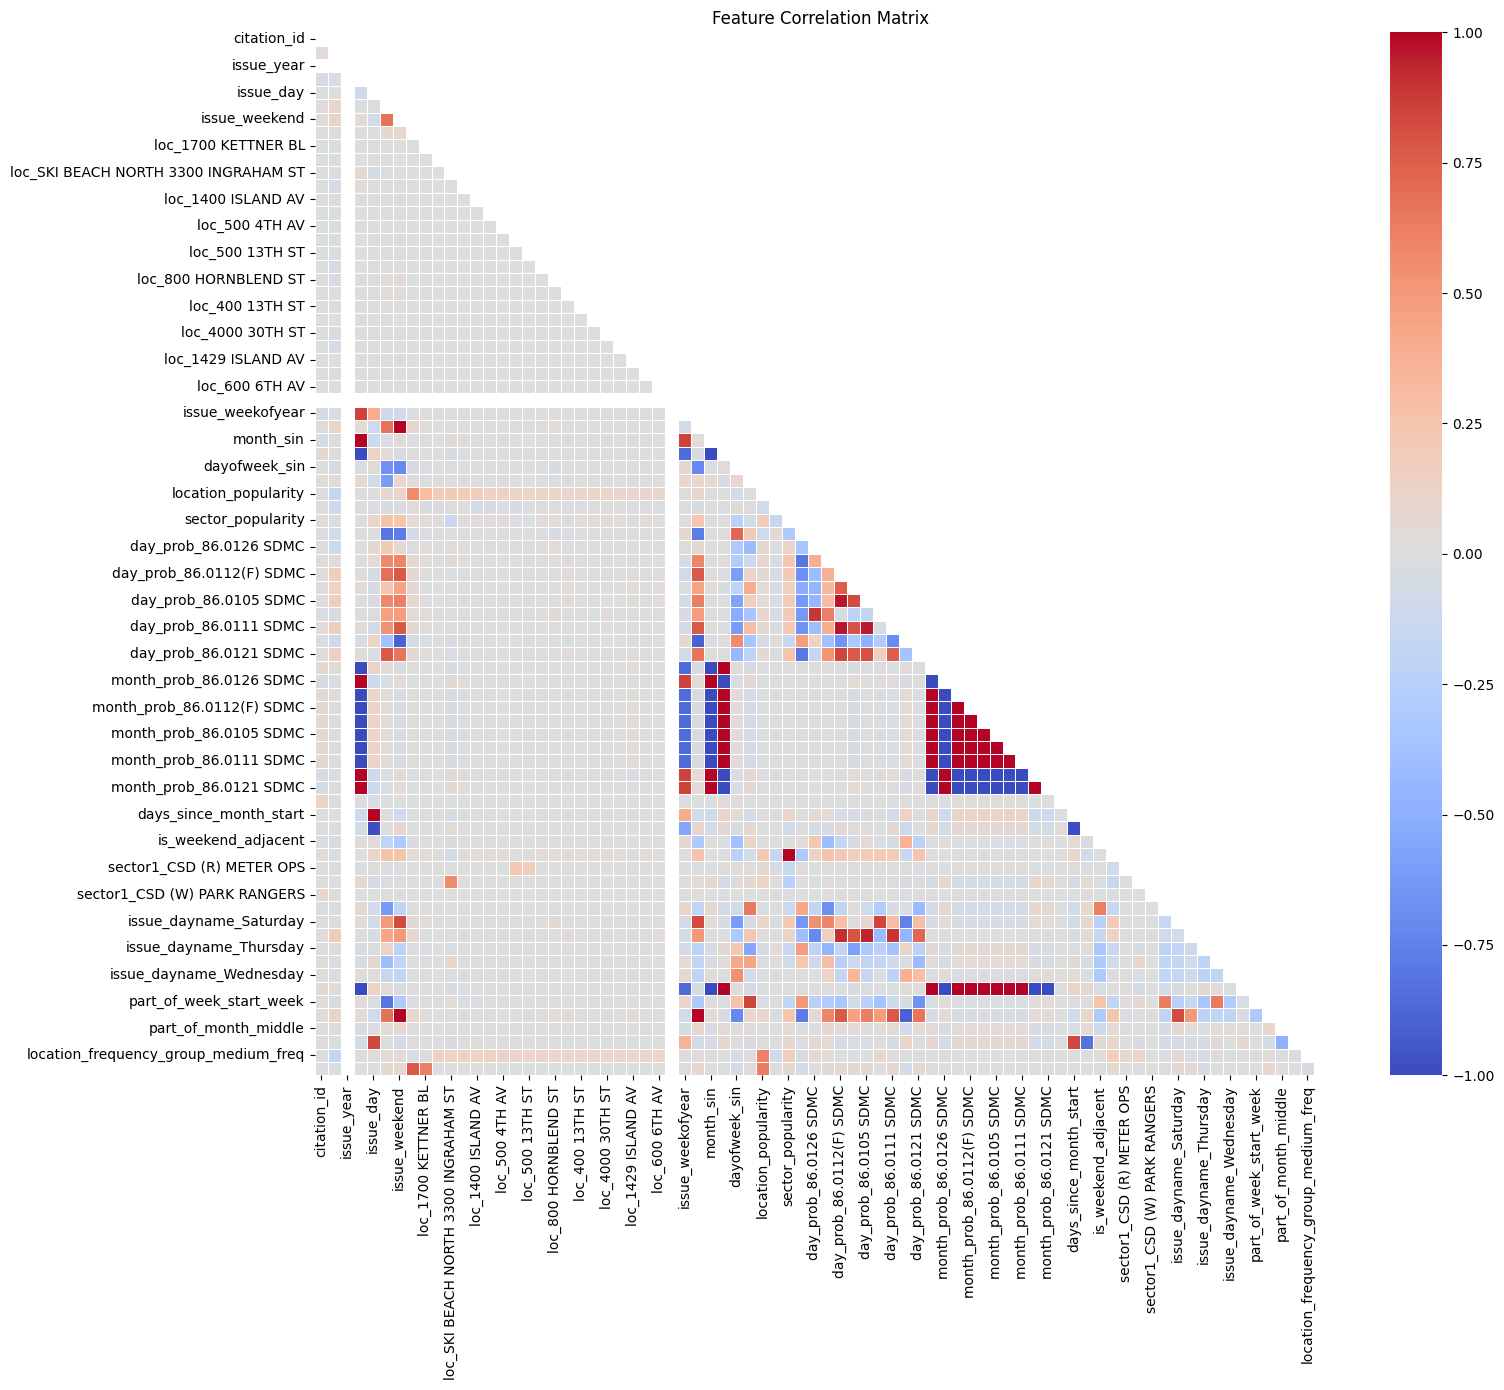

High correlation between issue_weekofyear and issue_month: 0.86
High correlation between is_weekend and issue_weekend: 1.00
High correlation between month_sin and issue_month: 1.00
High correlation between month_sin and issue_weekofyear: 0.86
High correlation between month_cos and issue_month: -1.00
High correlation between month_cos and issue_weekofyear: -0.86
High correlation between month_cos and month_sin: -1.00
High correlation between day_prob_86.0112(E)S DMC and issue_dayofweek: -0.81
High correlation between day_prob_86.0105 SDMC and day_prob_86.0112(F) SDMC: 0.96
High correlation between day_prob_86.0105 SDMC and day_prob_5204(A) CVC: 0.82
High correlation between day_prob_86.0119 SDMC and day_prob_86.0126 SDMC: 0.90
High correlation between day_prob_86.0111 SDMC and day_prob_86.0112(F) SDMC: 0.97
High correlation between day_prob_86.0111 SDMC and day_prob_86.0105 SDMC: 0.96
High correlation between day_prob_SDMC 86.2014 and issue_weekend: -0.91
High correlation between day_pr

c:\Users\tommy\miniforge3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 2 27] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\tommy\miniforge3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



Top 20 most important features:
                                 Feature         Score
1                               vio_fine  2.667390e+06
61           sector1_CSD (I) PARKING ENF  1.213832e+05
36                     sector_popularity  5.893052e+04
34                   location_popularity  1.726473e+03
76  location_frequency_group_medium_freq  1.418400e+03
37              day_prob_86.0112(E)S DMC  1.122876e+03
40              day_prob_86.0112(F) SDMC  9.743570e+02
44                 day_prob_86.0111 SDMC  9.348622e+02
46                 day_prob_86.0121 SDMC  9.128669e+02
42                 day_prob_86.0105 SDMC  9.104940e+02
73                  part_of_week_weekend  8.381283e+02
6                          issue_weekend  8.381283e+02
29                            is_weekend  8.381283e+02
35        matches_location_top_violation  7.630525e+02
5                        issue_dayofweek  7.630056e+02
67                  issue_dayname_Sunday  7.175014e+02
39              day_prob_86.0112

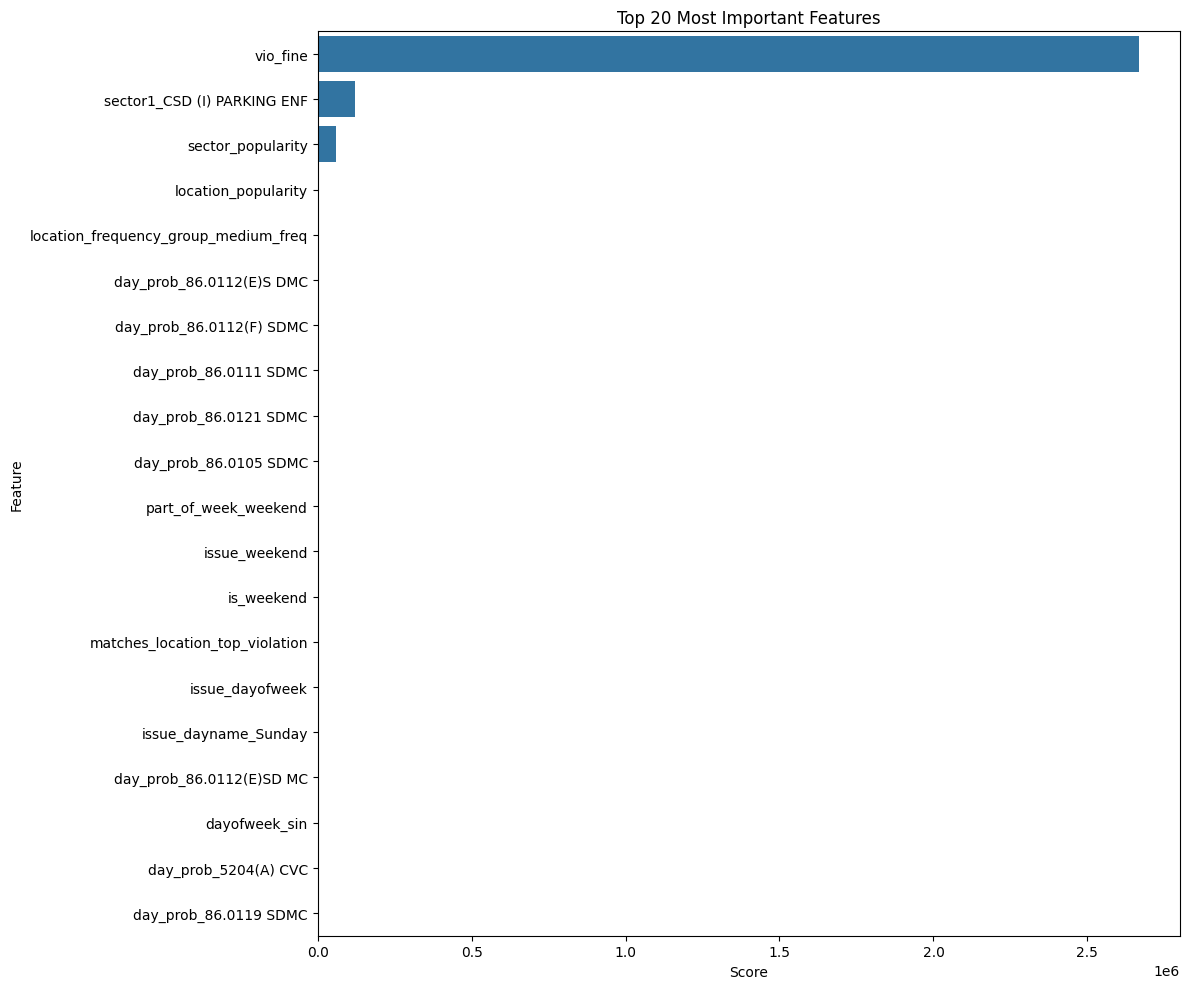

In [ ]:
# Prepare feature set for potential dimensionality reduction

# Get list of columns excluding target and string/object columns that haven't been encoded yet
non_feature_cols = [target_column, 'date_issue', 'date_creation', 'vio_desc', 'location', 
                    'loc_day_interaction', 'loc_month_interaction', 'sector_day_interaction', 
                    'sector_month_interaction', 'season_location']

# Identify categorical columns that need encoding
# Identify categorical columns that need encoding
categorical_cols = [col for col in citations_filtered.columns 
                    if col not in non_feature_cols 
                    and (citations_filtered[col].dtype == 'object' 
                         or col == 'part_of_month'
                         or col == 'location_frequency_group'
                         or pd.api.types.is_categorical_dtype(citations_filtered[col]))
                    and col != target_column]

print(f"Categorical columns to encode: {categorical_cols}")

# One-hot encode categorical features
citations_encoded = pd.get_dummies(
    citations_filtered,
    columns=categorical_cols,
    drop_first=True
)

print(f"After one-hot encoding categorical features, shape: {citations_encoded.shape}")

# Find numerical columns
numerical_cols = [col for col in citations_encoded.columns 
                  if col not in non_feature_cols 
                  and col != target_column
                  and pd.api.types.is_numeric_dtype(citations_encoded[col])]

print(f"Number of numerical features: {len(numerical_cols)}")

# Check correlation between numerical features
correlation_matrix = citations_encoded[numerical_cols].corr()

plt.figure(figsize=(16, 14))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Check for highly correlated features (|r| > 0.8)
high_corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            high_corr_features.add(feature_i)
            print(f"High correlation between {feature_i} and {feature_j}: {correlation_matrix.iloc[i, j]:.2f}")

print(f"Number of highly correlated features: {len(high_corr_features)}")

# Label encode the target for modeling
label_encoder = LabelEncoder()
citations_encoded['vio_code_encoded'] = label_encoder.fit_transform(citations_encoded[target_column])

# Identify most important features using chi-squared test (for classification)

# We'll select features for the encoded target variable

# First, let's filter only numeric columns (excluding the target and its encoded version)
X_features = citations_encoded.drop(columns=[target_column, 'vio_code_encoded'] + non_feature_cols)
y_target = citations_encoded['vio_code_encoded']

# Apply SelectKBest with chi-squared test
k_best = min(50, X_features.shape[1])  # Select up to 50 features
selector = SelectKBest(score_func=f_classif, k=k_best)
selector.fit(X_features, y_target)

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': X_features.columns,
    'Score': selector.scores_
})

feature_scores = feature_scores.sort_values('Score', ascending=False)
print("\nTop 20 most important features:")
print(feature_scores.head(20))

plt.figure(figsize=(12, 10))
top_n = 20
top_features = feature_scores.head(top_n)
sns.barplot(x='Score', y='Feature', data=top_features)
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.show()

### 2.9 Create Final Feature Set for Modeling

In [44]:
# Based on feature importance, keep only the most relevant features
top_features_list = feature_scores.head(50)['Feature'].tolist()  # Adjust number as needed

# Create final feature set
X_final = X_features[top_features_list].copy()
print(f"Final feature set shape: {X_final.shape}")

modeling_data = pd.concat([X_final, citations_encoded[['vio_code_encoded', target_column]]], axis=1)
modeling_data.head()

Final feature set shape: (74381, 50)


,vio_fine,sector1_CSD (I) PARKING ENF,sector_popularity,location_popularity,location_frequency_group_medium_freq,day_prob_86.0112(E)S DMC,day_prob_86.0112(F) SDMC,day_prob_86.0111 SDMC,day_prob_86.0121 SDMC,day_prob_86.0105 SDMC,...,loc_1700 KETTNER BL,part_of_month_end,loc_4000 30TH ST,loc_800 HORNBLEND ST,loc_500 4TH AV,is_weekend_adjacent,part_of_month_middle,loc_1400 ISLAND AV,vio_code_encoded,vio_code
0,37.5,True,55514,1,False,0.243524,0.076956,0.02869,0.036875,0.042866,...,0,False,0,0,0,0,False,0,0,5204(A) CVC
2,37.5,True,55514,3,False,0.243524,0.076956,0.02869,0.036875,0.042866,...,0,False,0,0,0,0,False,0,0,5204(A) CVC
5,37.5,True,55514,3,False,0.243524,0.076956,0.02869,0.036875,0.042866,...,0,False,0,0,0,0,False,0,0,5204(A) CVC
6,37.5,True,55514,3,False,0.243524,0.076956,0.02869,0.036875,0.042866,...,0,False,0,0,0,0,False,0,0,5204(A) CVC
7,37.5,True,55514,2,False,0.243524,0.076956,0.02869,0.036875,0.042866,...,0,False,0,0,0,0,False,0,0,5204(A) CVC


# 3. Model Building and Evaluation for Parking Citation Prediction

### 3.1 Prepare Training and Testing Data

In [45]:
# Define features and target
if 'vio_code' in modeling_data.columns and 'vio_code_encoded' in modeling_data.columns:
    X = modeling_data.drop(['vio_code', 'vio_code_encoded'], axis=1)
    y = modeling_data['vio_code_encoded']
elif 'vio_code_encoded' in modeling_data.columns:
    X = modeling_data.drop(['vio_code_encoded'], axis=1)
    y = modeling_data['vio_code_encoded']
elif 'vio_code' in modeling_data.columns:
    from sklearn.preprocessing import LabelEncoder
    X = modeling_data.drop(['vio_code'], axis=1)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(modeling_data['vio_code'])
    print("Created encoded target variable 'vio_code_encoded'")

# Verify shape
print(f"Feature set shape: {X.shape}")
print(f"Target set shape: {y.shape}")

Feature set shape: (74381, 50)
Target set shape: (74381,)


In [46]:
# Check for NaN values in features
nan_count = X.isna().sum().sum()
nan_count

np.int64(0)

In [47]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Feature scaling (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set size: 55785 samples
Testing set size: 18596 samples


### 3.2 Implement Baseline Models

In [48]:
# Check if we have too many target classes (might need to adjust models)
num_classes = len(np.unique(y))
print(f"Number of target classes: {num_classes}")

# Define baseline models with adjusted parameters if needed
baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, 
                                             multi_class='multinomial', 
                                             solver='lbfgs'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, 
                                           n_jobs=-1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
}

# If the number of classes is manageable, include more models
if num_classes < 100:  # For very large numbers of classes, some models might be too slow
    baseline_models['Gradient Boosting'] = GradientBoostingClassifier(
        n_estimators=100, random_state=42)
    baseline_models['SVM'] = SVC(probability=True, random_state=42, 
                                decision_function_shape='ovr')


Number of target classes: 10


In [49]:
# Function to evaluate model performance
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    print(f"\nEvaluating {name}...")
    
    # Train the model and measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Inference time: {inference_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 score (weighted): {f1:.4f}")
    
    # Generate classification report (abbreviated for large number of classes)
    if num_classes > 20:
        # Get most common classes in test set for focused reporting
        top_classes = np.unique(y_test, return_counts=True)
        top_class_indices = np.argsort(top_classes[1])[-10:]  # Top 10 most frequent classes
        top_class_values = top_classes[0][top_class_indices]
        
        # Create a mask for the top classes
        mask = np.isin(y_test, top_class_values)
        test_subset = y_test[mask]
        pred_subset = y_pred[mask]
        
        print("\nClassification Report (Top 10 most frequent classes):")
        print(classification_report(test_subset, pred_subset))
    else:
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    
    return {
        'name': name,
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'train_time': train_time,
        'inference_time': inference_time
    }



Evaluating Logistic Regression...


c:\Users\tommy\miniforge3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\tommy\miniforge3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tommy\miniforge3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tommy\miniforge3\Lib\site-packages\sklearn\metrics\_classifi

Training time: 6.47 seconds
Inference time: 0.00 seconds
Accuracy: 0.8918
Precision (weighted): 0.8703
Recall (weighted): 0.8918
F1 score (weighted): 0.8688

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1437
           1       0.68      0.18      0.28      1003
           2       0.65      0.61      0.63       687
           3       1.00      1.00      1.00      4484
           4       0.68      0.97      0.80      3139
           5       1.00      1.00      1.00      1810
           6       1.00      1.00      1.00       809
           7       0.53      0.57      0.55       529
           8       1.00      1.00      1.00      4115
           9       0.00      0.00      0.00       583

    accuracy                           0.89     18596
   macro avg       0.75      0.73      0.73     18596
weighted avg       0.87      0.89      0.87     18596


Evaluating Decision Tree...
Training time: 0.26 seconds
Inf

c:\Users\tommy\miniforge3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tommy\miniforge3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tommy\miniforge3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tommy\miniforge3\Lib\site-pa

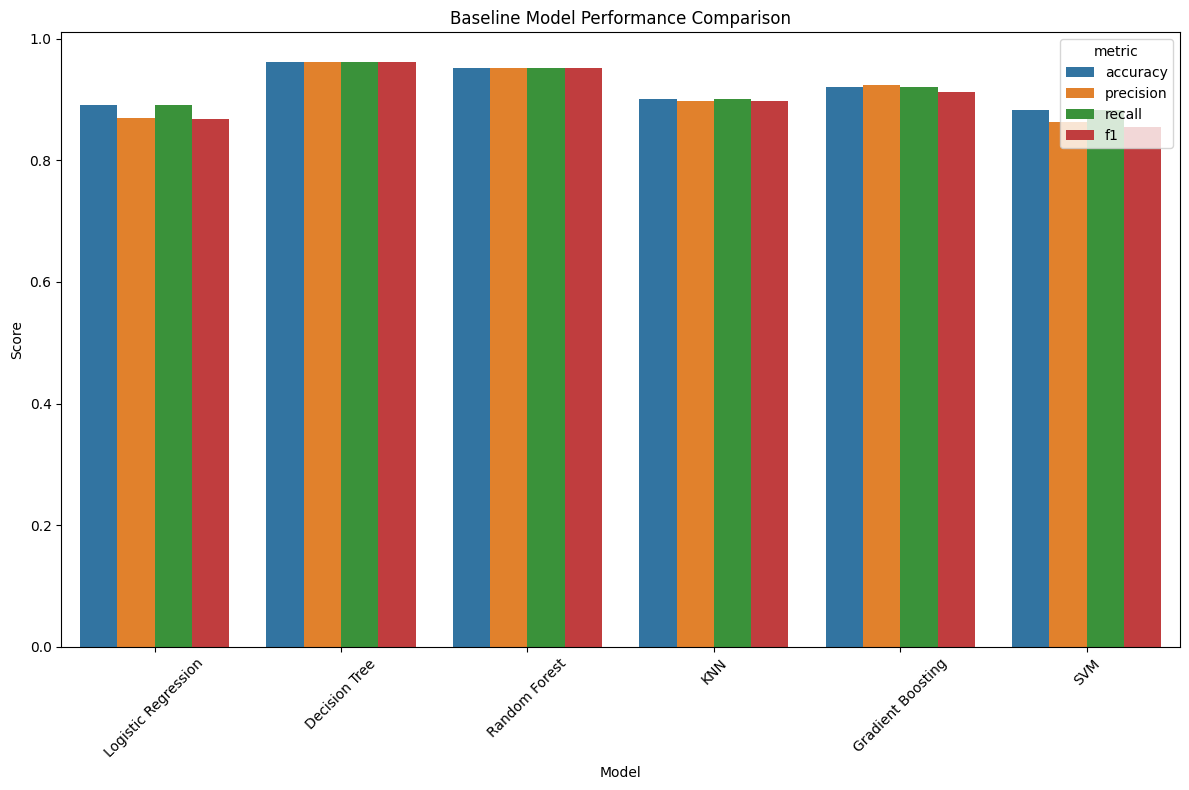

In [ ]:
# Evaluate each baseline model
baseline_results = []
for name, model in baseline_models.items():
    try:
        result = evaluate_model(name, model, X_train_scaled, X_test_scaled, y_train, y_test)
        baseline_results.append(result)
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")

# Compare baseline models
if baseline_results:
    baseline_df = pd.DataFrame(baseline_results)
    print("\nBaseline Model Comparison:")
    print(baseline_df[['name', 'accuracy', 'precision', 'recall', 'f1', 'train_time', 'inference_time']])

    plt.figure(figsize=(12, 8))
    performance_metrics = baseline_df[['name', 'accuracy', 'precision', 'recall', 'f1']]
    performance_metrics = performance_metrics.melt(
        id_vars='name', 
        var_name='metric', 
        value_name='value'
    )
    sns.barplot(x='name', y='value', hue='metric', data=performance_metrics)
    plt.title('Baseline Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('baseline_model_comparison.png')
    plt.show()

### 3.3 Implement Advanced Models

In [ ]:
# Try XGBoost model with adjusted parameters
try:
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=num_classes,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    
    # Evaluate XGBoost
    xgb_result = evaluate_model('XGBoost', xgb_model, X_train_scaled, X_test_scaled, y_train, y_test)
    baseline_results.append(xgb_result)
except Exception as e:
    print(f"Error with XGBoost model: {str(e)}")


Evaluating XGBoost...
Training time: 0.70 seconds
Inference time: 0.01 seconds
Accuracy: 0.9268
Precision (weighted): 0.9301
Recall (weighted): 0.9268
F1 score (weighted): 0.9179

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1437
           1       0.81      0.34      0.48      1003
           2       0.84      0.88      0.86       687
           3       1.00      1.00      1.00      4484
           4       0.75      0.96      0.84      3139
           5       1.00      1.00      1.00      1810
           6       1.00      1.00      1.00       809
           7       0.83      0.78      0.81       529
           8       1.00      1.00      1.00      4115
           9       0.82      0.34      0.48       583

    accuracy                           0.93     18596
   macro avg       0.91      0.83      0.85     18596
weighted avg       0.93      0.93      0.92     18596



In [52]:
# Try LightGBM model with adjusted parameters
print("\nTraining LightGBM model...")
try:
    lgb_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=num_classes,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    
    # Evaluate LightGBM
    lgb_result = evaluate_model('LightGBM', lgb_model, X_train_scaled, X_test_scaled, y_train, y_test)
    baseline_results.append(lgb_result)
except Exception as e:
    print(f"Error with LightGBM model: {str(e)}")


Training LightGBM model...

Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 55785, number of used features: 50
[LightGBM] [Info] Start training from score -2.560799
[LightGBM] [Info] Start training from score -2.920562
[LightGBM] [Info] Start training from score -3.297829
[LightGBM] [Info] Start training from score -1.422452
[LightGBM] [Info] Start training from score -1.779201
[LightGBM] [Info] Start training from score -2.329382
[LightGBM] [Info] Start training from score -3.134025
[LightGBM] [Info] Start training from score -3.559660
[LightGBM] [Info] Start training from score -1.508335
[LightGBM] [Info] Start training from score -3.461889
[LightGBM] [Warning] No further splits with positive gai

c:\Users\tommy\miniforge3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [53]:
# Update results with advanced models
all_results = baseline_results
all_models_df = pd.DataFrame(all_results)

# Compare all models
print("\nAll Models Comparison:")
print(all_models_df[['name', 'accuracy', 'precision', 'recall', 'f1', 'train_time', 'inference_time']])


All Models Comparison:
                  name  accuracy  precision    recall        f1  train_time  \
0  Logistic Regression  0.891751   0.870263  0.891751  0.868784    6.469454   
1        Decision Tree  0.962411   0.962126  0.962411  0.962237    0.257123   
2        Random Forest  0.952678   0.951675  0.952678  0.951863    0.442761   
3                  KNN  0.900409   0.897259  0.900409  0.897708    0.016001   
4    Gradient Boosting  0.920682   0.923889  0.920682  0.911602   75.132735   
5                  SVM  0.882609   0.863849  0.882609  0.855420   69.938499   
6              XGBoost  0.926812   0.930129  0.926812  0.917875    0.704018   
7             LightGBM  0.943160   0.943708  0.943160  0.939196    1.046030   

   inference_time  
0        0.004001  
1        0.004000  
2        0.067030  
3        1.648775  
4        0.169124  
5       14.915866  
6        0.009001  
7        0.050001  


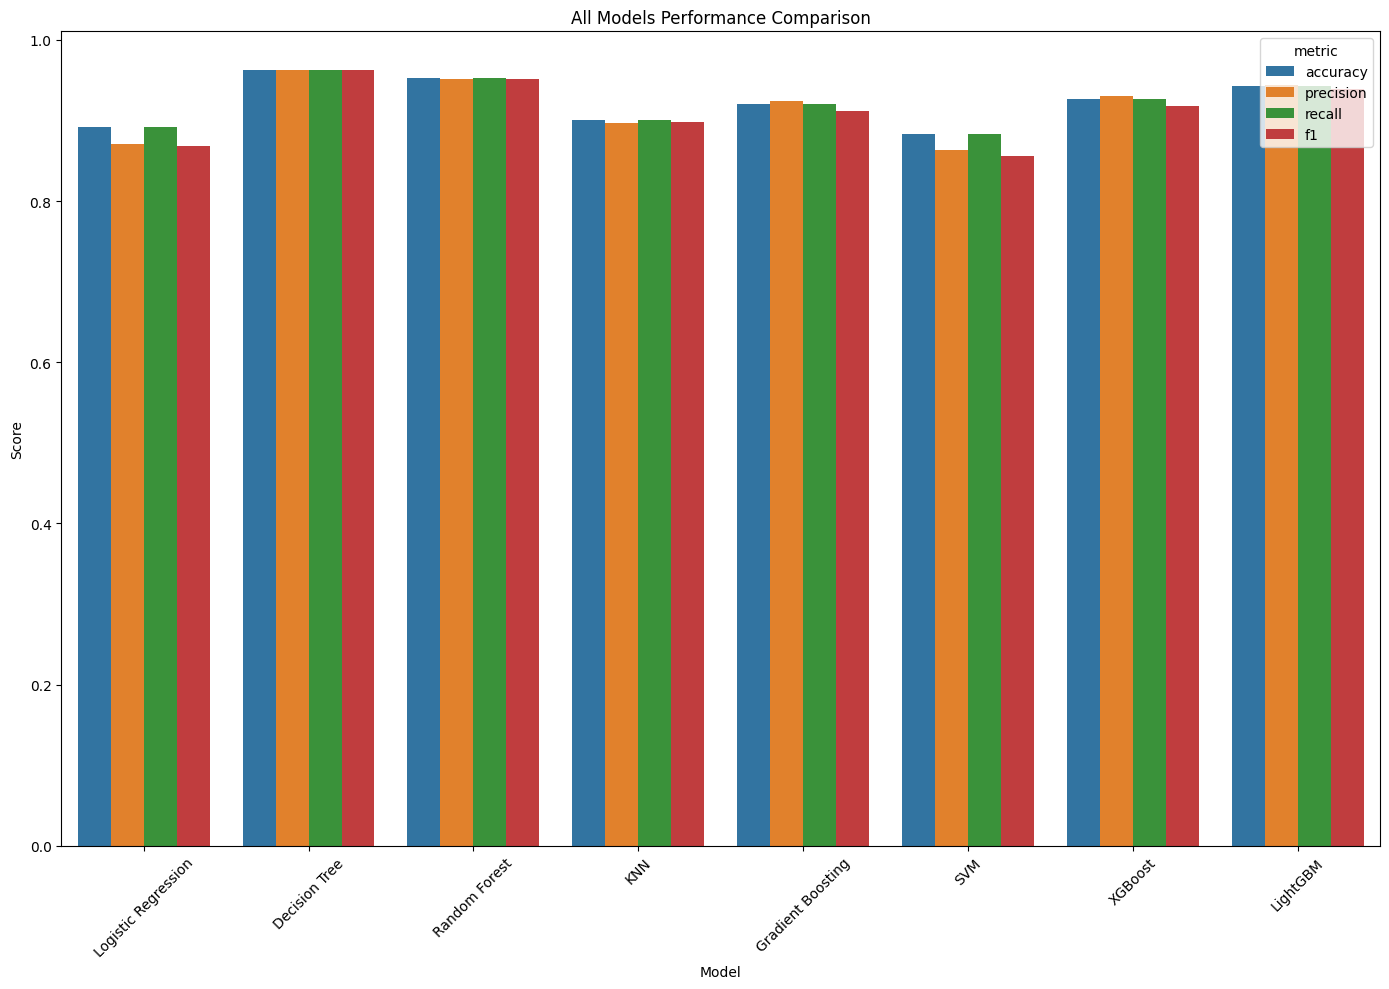

In [ ]:
plt.figure(figsize=(14, 10))
performance_metrics = all_models_df[['name', 'accuracy', 'precision', 'recall', 'f1']]
performance_metrics = performance_metrics.melt(
    id_vars='name', 
    var_name='metric', 
    value_name='value'
)
sns.barplot(x='name', y='value', hue='metric', data=performance_metrics)
plt.title('All Models Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('all_models_comparison.png')
plt.show()

### 3.4 Identify and Optimize Best Model

In [55]:
# Find the best model based on F1 score
best_model_idx = all_models_df['f1'].idxmax()
best_model_result = all_models_df.loc[best_model_idx]
best_model_name = best_model_result['name']
print(f"Best performing model based on F1 score: {best_model_name} with F1 score of {best_model_result['f1']:.4f}")

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'max_iter': [1000, 2000]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'min_samples_split': [2, 5]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 63, 127]
    }
}

# Perform hyperparameter tuning
print(f"Performing hyperparameter tuning for {best_model_name}...")

# Get model class and parameter grid
best_model = all_results[best_model_idx]['model']
param_grid = param_grids[best_model_name]

# Setup grid search with cross-validation
grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,  # Using 3-fold CV for speed, increase for better estimates
    n_jobs=-1,
    verbose=1
)

# Fit grid search to the data
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
best_tuned_model = grid_search.best_estimator_
tuned_result = evaluate_model(f"{best_model_name} (Tuned)", 
                                best_tuned_model, 
                                X_train_scaled, X_test_scaled, 
                                y_train, y_test)

# Compare with the baseline model
print("\nComparison of Baseline vs. Tuned Model:")
baseline_f1 = best_model_result['f1']
tuned_f1 = tuned_result['f1']
improvement = (tuned_f1 - baseline_f1) / baseline_f1 * 100
print(f"F1 Score: {baseline_f1:.4f} -> {tuned_f1:.4f}")
print(f"Improvement: {improvement:.2f}%")

# Update the best model for further analysis
best_model_object = best_tuned_model

Best performing model based on F1 score: Decision Tree with F1 score of 0.9622
Performing hyperparameter tuning for Decision Tree...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.9513

Evaluating Decision Tree (Tuned)...
Training time: 0.14 seconds
Inference time: 0.00 seconds
Accuracy: 0.9624
Precision (weighted): 0.9621
Recall (weighted): 0.9624
F1 score (weighted): 0.9622

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1437
           1       0.76      0.73      0.75      1003
           2       0.91      0.92      0.91       687
           3       1.00      1.00      1.00      4484
           4       0.91      0.92      0.92      3139
           5       1.00      1.00      1.00      1810
           6       1.00      1.00      1.00       809
           7       0.89      0.88 

### 3.5 Feature Importance Analysis


Top 20 Most Important Features:
                           Feature  Importance
0                         vio_fine    0.553309
2                sector_popularity    0.257170
38                     citation_id    0.101817
3              location_popularity    0.042387
13  matches_location_top_violation    0.007885
36                       issue_day    0.006997
37          days_since_month_start    0.005950
34            days_until_month_end    0.005117
8            day_prob_86.0121 SDMC    0.003113
48            part_of_month_middle    0.002044
20          issue_dayname_Saturday    0.001542
9            day_prob_86.0105 SDMC    0.001235
23         part_of_week_start_week    0.001188
16        day_prob_86.0112(E)SD MC    0.001080
6         day_prob_86.0112(F) SDMC    0.001016
19           day_prob_86.0119 SDMC    0.000976
47             is_weekend_adjacent    0.000933
18            day_prob_5204(A) CVC    0.000836
43               part_of_month_end    0.000658
22           day_prob_SDMC 

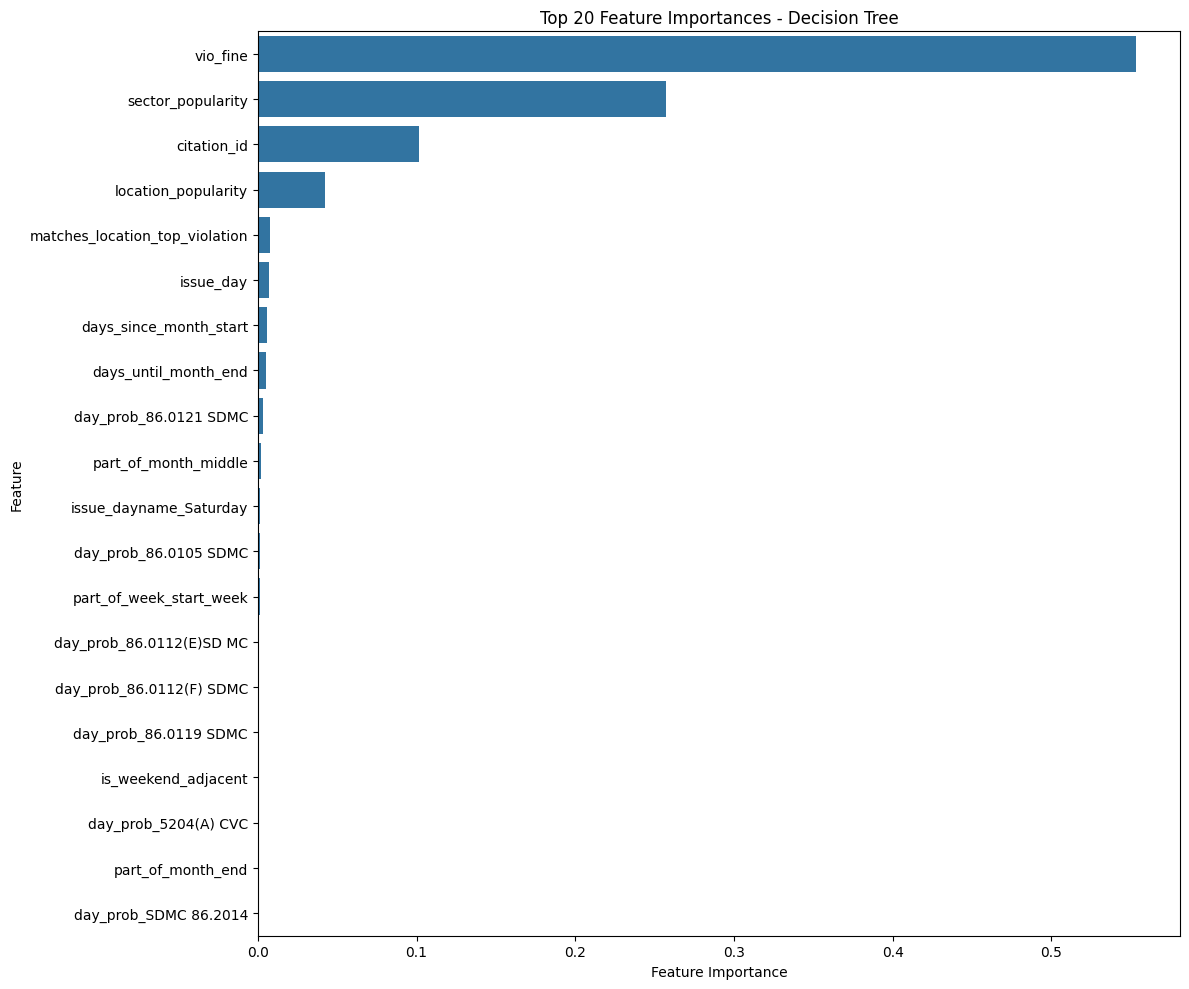

In [ ]:
# # Try to extract feature importance from the best model
# if hasattr(best_model_object, 'feature_importances_'):
# Get feature importances
feature_importances = best_model_object.feature_importances_

# Create a dataframe for easier manipulation
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Display top 20 important features
print("\nTop 20 Most Important Features:")
print(importance_df.head(20))

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title(f'Top 20 Feature Importances - {best_model_name}')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

### 3.6 Confusion Matrix Analysis

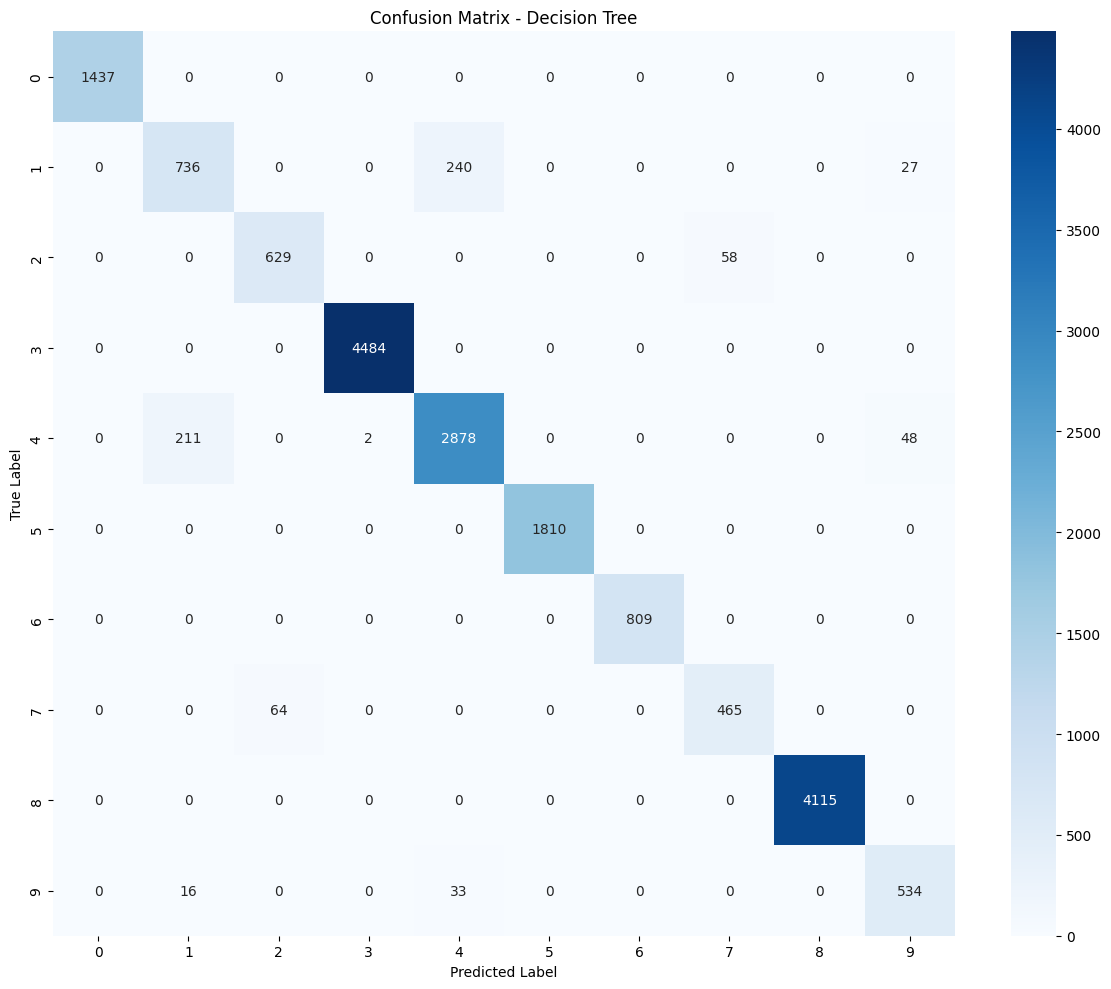


Per-class Performance Metrics:
              precision    recall  f1-score       support
0              1.000000  1.000000  1.000000   1437.000000
1              0.764278  0.733799  0.748728   1003.000000
2              0.907648  0.915575  0.911594    687.000000
3              0.999554  1.000000  0.999777   4484.000000
4              0.913361  0.916853  0.915103   3139.000000
5              1.000000  1.000000  1.000000   1810.000000
6              1.000000  1.000000  1.000000    809.000000
7              0.889101  0.879017  0.884030    529.000000
8              1.000000  1.000000  1.000000   4115.000000
9              0.876847  0.915952  0.895973    583.000000
accuracy       0.962411  0.962411  0.962411      0.962411
macro avg      0.935079  0.936120  0.935521  18596.000000
weighted avg   0.962126  0.962411  0.962237  18596.000000


In [57]:
# Generate predictions with the best model
y_pred = best_model_object.predict(X_test_scaled)

# Create standard confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Calculate per-class metrics
print("\nPer-class Performance Metrics:")
class_report = classification_report(y_test, y_pred, output_dict=True)
class_df = pd.DataFrame(class_report).T
print(class_df)

### 3.7 Cross-Validation Analysis

Cross-validation F1 scores: [0.95450965 0.95118905 0.95588837 0.95357989 0.95414508]
Mean F1 score: 0.9539
Standard deviation: 0.0015


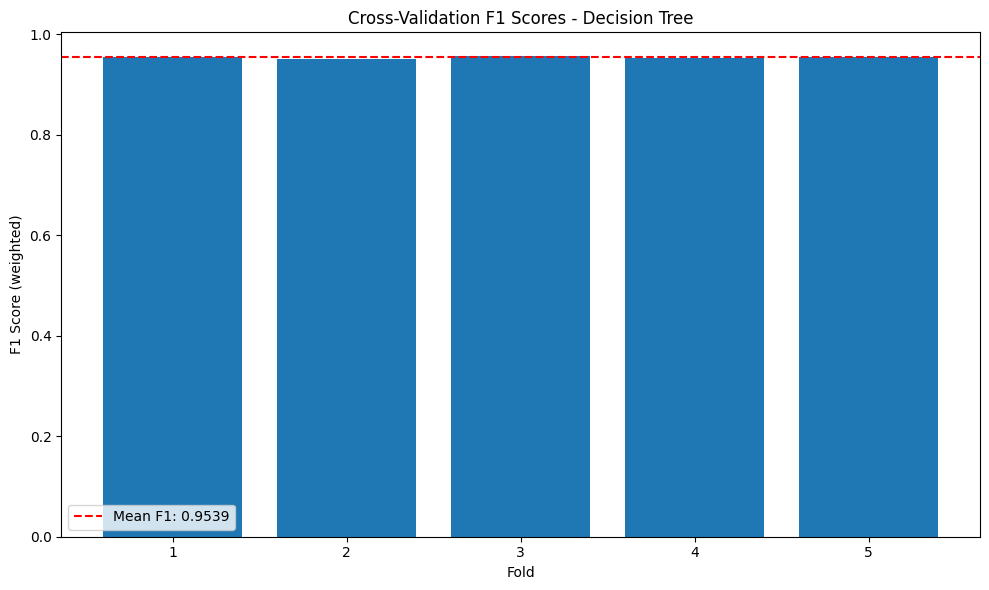

In [ ]:
# Perform cross-validation with the best model
cv_scores = cross_val_score(
    best_model_object, 
    X_train_scaled, 
    y_train, 
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1
)

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean F1 score: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(cv_scores) + 1), cv_scores)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', 
            label=f'Mean F1: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('F1 Score (weighted)')
plt.title(f'Cross-Validation F1 Scores - {best_model_name}')
plt.legend()
plt.tight_layout()
plt.savefig('cross_validation_scores.png')
plt.show()